
# Set up the notebook

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from scipy import stats
from scipy.stats import pearsonr
from stats_charting_utils import StatsChartingUtilities
from stats_scraping_utils import StatsScrapingUtilities
from storage import Storage
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import textwrap
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

s = Storage()
ssu = StatsScrapingUtilities(s=s)
scu = StatsChartingUtilities(s=s)


----


# Prepare the Pandemics scatterplot


## Get the Basic Reproduction Number data

In [3]:

ev_explanation_str = 'Basic Reproduction Number'
url = 'https://en.wikipedia.org/wiki/Basic_reproduction_number'
print(f'The {ev_explanation_str} data is from {url}.')
R0s_df = s.load_object('R0s_df')

The Basic Reproduction Number data is from https://en.wikipedia.org/wiki/Basic_reproduction_number.



## Get the Case Fatality Rate data

In [4]:

rv_explanation_str = 'Case Fatality Rate'
url = 'https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates'
print(f'The {rv_explanation_str} data is from {url}.')
CFRs_df = s.load_object('CFRs_df')

The Case Fatality Rate data is from https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates.



## Prepare the data for merging

In [5]:

# Remove disease misspellings
diseases_list = sorted(set(R0s_df.short_disease_name).symmetric_difference(set(CFRs_df.short_disease_name)))
if diseases_list:
    print(diseases_list)
doubles_df = ssu.check_4_doubles(diseases_list)
mask_series = (doubles_df.max_similarity > 0.6)
if doubles_df[mask_series].shape[0]:
    columns_list = ['first_item', 'second_item', 'max_similarity']
    display(doubles_df[mask_series][columns_list].sort_values('max_similarity', ascending=False))

['2009 Flu', '2014 Ebola', 'Alphaherpesvirus', 'Angiostrongyliasis', 'Aspergillosis', 'Baylisascariasis', 'Botulism', 'Brucellosis', 'Bubonic Plague', 'COVID-19 Alpha', 'COVID-19 Delta', 'COVID-19 Omicron', 'Capillariasis', 'Cholera', 'Cutaneous Anthrax', 'DHF', 'Diphtheria', 'EBOV', 'EEE', 'Encephalopathies', 'GAE', 'Glanders', 'HFMD', 'HPS', 'Hepatitis A', 'Influenza A', 'Intestinal Anthrax', 'Lassa', 'Legionellosis', 'Leishmaniasis', 'Leptospirosis', 'ME', 'Malaria', 'Marburg', 'Measles', 'Meningitis', 'Meningoencephalitis', 'Mucormycosis', 'Mumps', 'Nipah', 'Oropharyngeal Anthrax', 'Pneumonic Plague', 'Pneumonic Tularemia', 'Pulmonary Anthrax', 'Rabies', 'Respiratory Diphtheria', 'Rhinovirus', 'Rubella', 'Rubeola', 'Septicemic Plague', 'Sleeping Sickness', 'Smallpox', 'Tetanus', 'Tuberculosis', 'Typhoid', 'Typhoidal Tularemia', 'VEE', 'Variola Major', 'Variola Minor', 'Yellow fever']


,first_item,second_item,max_similarity
47,Rubella,Rubeola,0.857143
57,Variola Major,Variola Minor,0.846154
8,Bubonic Plague,Pneumonic Plague,0.800000
9,COVID-19 Alpha,COVID-19 Delta,0.785714
41,Pneumonic Plague,Pneumonic Tularemia,0.742857
4,Aspergillosis,Legionellosis,0.692308
35,Meningitis,Meningoencephalitis,0.689655
18,EEE,VEE,0.666667
40,Oropharyngeal Anthrax,Pulmonary Anthrax,0.631579
42,Pneumonic Tularemia,Typhoidal Tularemia,0.631579


In [6]:

# Assume all the variants are the same CFR as the original and add them in
mask_series = (CFRs_df.short_disease_name == 'COVID-19')
c19_df = CFRs_df[mask_series]
c19_df.short_disease_name = 'COVID-19 Alpha'
c19_df.disease_name = 'COVID-19 (Alpha variant)'
CFRs_df = CFRs_df.append(c19_df)
c19_df.short_disease_name = 'COVID-19 Delta'
c19_df.disease_name = 'COVID-19 (Delta variant)'
CFRs_df = CFRs_df.append(c19_df)
c19_df.short_disease_name = 'COVID-19 Omicron'
c19_df.disease_name = 'COVID-19 (Omicron variant)'
CFRs_df = CFRs_df.append(c19_df)
mask_series = (CFRs_df.short_disease_name == 'Seasonal Flu')
flu_df = CFRs_df[mask_series]
flu_df.short_disease_name = '2009 Flu'
flu_df.disease_name = 'Influenza (2009 pandemic strain)'
CFRs_df = CFRs_df.append(flu_df)

In [7]:

# Get every disease duplicated across the two datasets if possble
typos_df = ssu.check_for_typos(R0s_df.short_disease_name.unique(), CFRs_df.short_disease_name.unique(),
                               verbose=False).rename(columns={'left_item': 'R0', 'right_item': 'CFR'})
mask_series = (typos_df.max_similarity < 1.0)
df = typos_df[mask_series].sort_values(['max_similarity', 'R0', 'CFR'], ascending=[False, True, True])
f_str = f"There are a large number of {ev_explanation_str} (R0s) I don't have {rv_explanation_str}s (CFRs) for: "
print(f_str + ssu.conjunctify_nouns(df.R0.tolist()) + '.')
df

There are a large number of Basic Reproduction Number (R0s) I don't have Case Fatality Rates (CFRs) for: Rubella, Diphtheria, Rhinovirus, Measles, 2014 Ebola, Mumps, Smallpox, and Nipah.


,R0,CFR,max_similarity
4,Rubella,Rubeola,0.857143
13,Diphtheria,Respiratory Diphtheria,0.625000
14,Rhinovirus,Hantavirus,0.600000
0,Measles,Lassa,0.500000
17,2014 Ebola,Rubeola,0.470588
2,Mumps,Mucormycosis,0.470588
8,Smallpox,Seasonal Flu,0.400000
21,Nipah,Malaria,0.333333


In [8]:

# Get every disease duplicated across the two datasets if possble
typos_df = ssu.check_for_typos(CFRs_df.short_disease_name.unique(), R0s_df.short_disease_name.unique(),
                               verbose=False).rename(columns={'left_item': 'CFR', 'right_item': 'R0'})
mask_series = (typos_df.max_similarity < 1.0)
df = typos_df[mask_series].sort_values(['max_similarity', 'CFR', 'R0'], ascending=[False, True, True])
f_str = f"And, there are a large number of {rv_explanation_str}s (CFRs) I don't have {ev_explanation_str}s (R0s) for: "
print(f_str + ssu.conjunctify_nouns(df.CFR.tolist()) + '.')
df

And, there are a large number of Case Fatality Rates (CFRs) I don't have Basic Reproduction Numbers (R0s) for: Rubeola, ME, Respiratory Diphtheria, Tuberculosis, Leptospirosis, Variola Major, Variola Minor, Brucellosis, Lassa, Malaria, Tetanus, Hepatitis A, Botulism, Cholera, Mucormycosis, Alphaherpesvirus, Rabies, Aspergillosis, Capillariasis, Leishmaniasis, Glanders, Encephalopathies, Pneumonic Plague, Meningitis, Intestinal Anthrax, Legionellosis, Oropharyngeal Anthrax, Bubonic Plague, Septicemic Plague, Typhoid, DHF, Angiostrongyliasis, Marburg, Meningoencephalitis, Typhoidal Tularemia, EBOV, HFMD, HPS, VEE, Cutaneous Anthrax, Pneumonic Tularemia, Baylisascariasis, Yellow fever, Pulmonary Anthrax, Sleeping Sickness, EEE, GAE, and Influenza A.


,CFR,R0,max_similarity
45,Rubeola,Rubella,0.857143
50,ME,MERS,0.666667
39,Respiratory Diphtheria,Diphtheria,0.625000
21,Tuberculosis,Pertussis,0.571429
33,Leptospirosis,Pertussis,0.545455
8,Variola Major,Varicella,0.545455
51,Variola Minor,Varicella,0.545455
46,Brucellosis,Varicella,0.500000
49,Lassa,Measles,0.500000
55,Malaria,Varicella,0.500000



# Prep the Pandemics scatterplot

In [9]:

kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
red_kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.5', fc='pink', alpha=0.5),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ev_column_name = 'R0_low'
rv_column_name = 'CFR_low'

column_description_dict = s.load_object('column_description_dict')
explanatory_variable = column_description_dict.get(ev_column_name, ev_column_name)
response_variable = column_description_dict.get(rv_column_name, rv_column_name)

svg_dir = os.path.join(s.saves_folder, 'svg')
os.makedirs(name=svg_dir, exist_ok=True)

In [10]:

merged_df = R0s_df.merge(CFRs_df, on='short_disease_name', suffixes=['_R0', '_CFR']).set_index('short_disease_name', drop=True)


# Create Various Scatterplots


## Create a Boxed Scatterplot with a Log Scale in the Vertical Direction

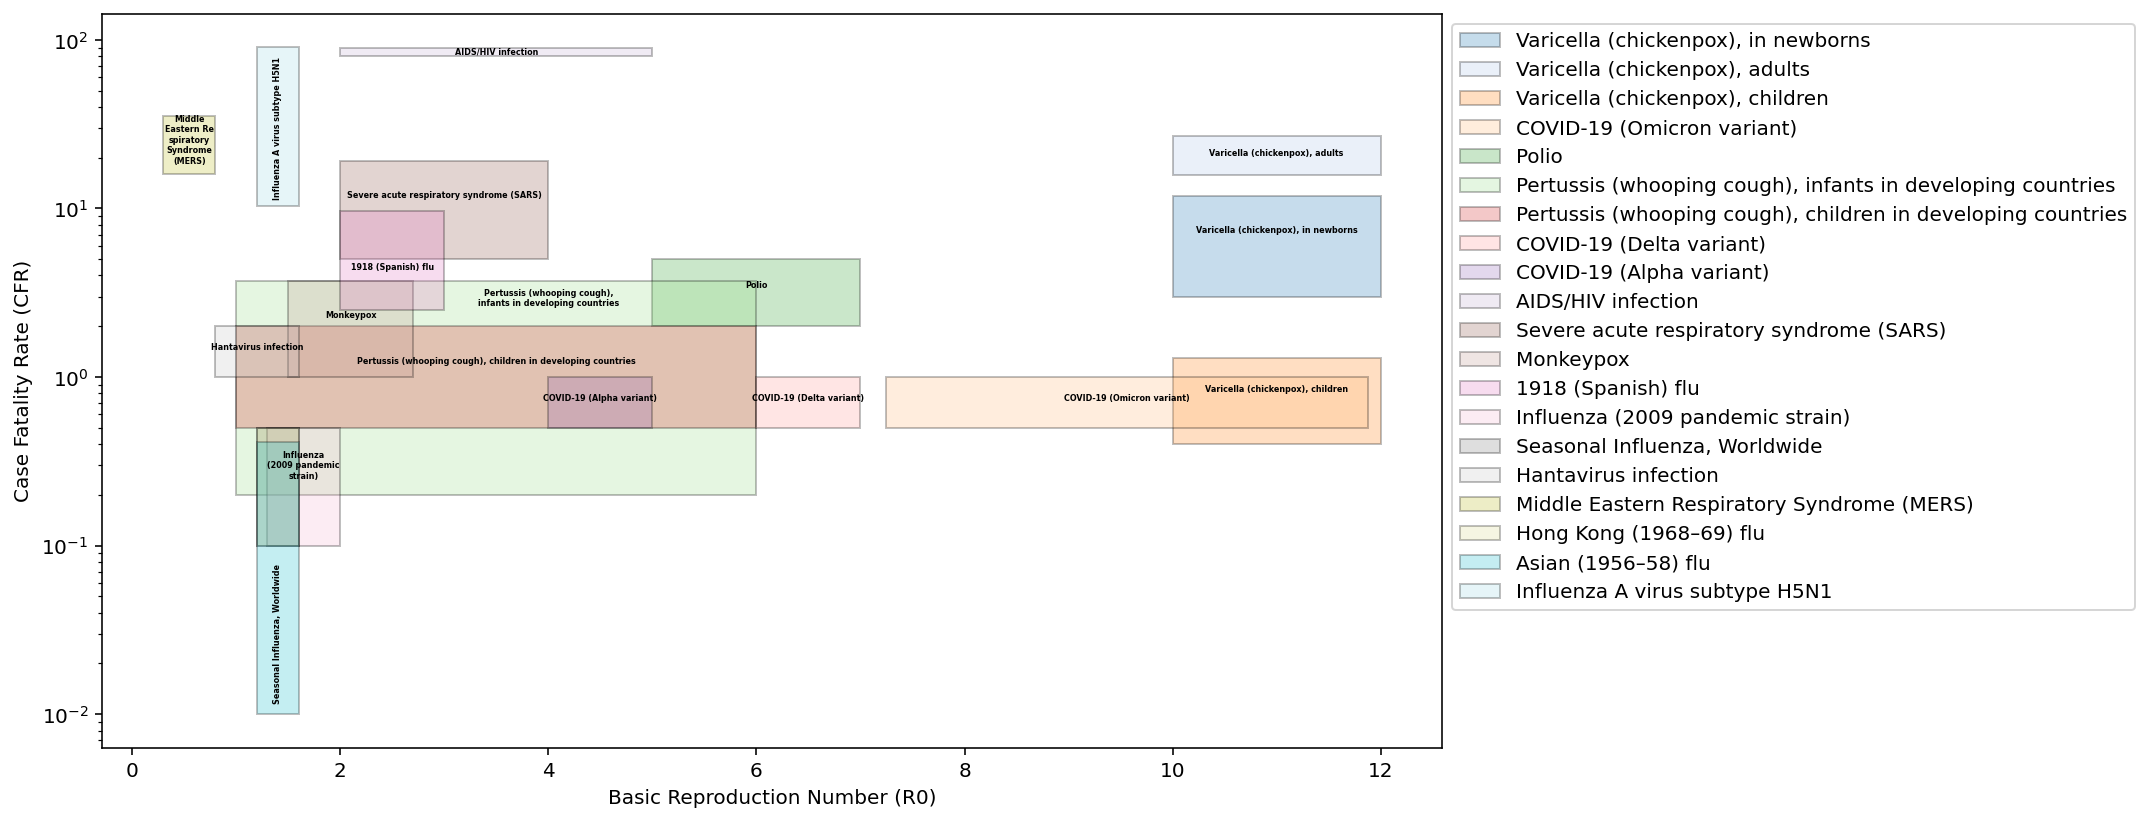

In [82]:

from matplotlib.patches import Rectangle

# The rectangle extends from xy[0] to xy[0] + width in x-direction
# and from xy[1] to xy[1] + height in y-direction. ::
#
#   :                +------------------+
#   :                |                  |
#   :              height               |
#   :                |                  |
#   :               (xy)---- width -----+
ev_low_column_name = 'R0_low'
ev_high_column_name = 'R0_high'
rv_low_column_name = 'CFR_low'
rv_high_column_name = 'CFR_high'
df = merged_df.reset_index(drop=False).set_index('disease_name_CFR', drop=True)
columns_list = [ev_low_column_name, ev_high_column_name, rv_low_column_name, rv_high_column_name]
df = df[columns_list].dropna()

fig_width = 12
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width*9/16))
ax.set_yscale('log')
merge_axes_subplot = plt.scatter(x=df[ev_low_column_name].tolist(), y=df[rv_low_column_name].tolist(), s=0, c=None, marker=None,
                                 cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors=None,
                                 plotnonfinite=False, data=df)
xlabel_text = plt.xlabel('{} ({})'.format(ev_explanation_str, explanatory_variable.replace('_low', '')))
ylabel_text = plt.ylabel('{} ({})'.format(rv_explanation_str, response_variable.replace('_low', '')))

# Add rectangles
color_cycler = scu.get_color_cycler(df.shape[0])
handles_list = []
textwrap_factor = 20
for label, x, y, x_plus_width, y_plus_height, face_color_dict in zip(df.index, df[ev_low_column_name], df[rv_low_column_name],
                                                                     df[ev_high_column_name], df[rv_high_column_name], color_cycler()):
    
    # Add rectangle
    rect_width = max(x_plus_width - x, .4)
    rect_height = max(y_plus_height - y, .4)
    rect_obj = ax.add_patch(Rectangle((x, y), rect_width, rect_height, fill=True, alpha=0.25,
                                      facecolor=face_color_dict['color'], edgecolor='black', label=label))
    handles_list.append(rect_obj)
    
    # Center text in rectangle
    rx, ry = rect_obj.get_xy()
    rect_width = rect_obj.get_width()
    cx = rx + rect_width/2.0
    rect_height = rect_obj.get_height()
    cy = ry + rect_height/2.0
    if(label == 'Varicella (chickenpox), in newborns'):
        t = ax.annotate('Varicella (chickenpox), in newborns', (11.0, 7.45), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'Varicella (chickenpox), adults'):
        t = ax.annotate('Varicella (chickenpox), adults', (11.0, 21.3), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'Varicella (chickenpox), children'):
        t = ax.annotate('Varicella (chickenpox), children', (11.0, 0.8500000000000001), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'COVID-19 (Omicron variant)'):
        t = ax.annotate('COVID-19 (Omicron variant)', (9.565000057220459, 0.75), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'Polio'):
        t = ax.annotate('Polio', (6.0, 3.5), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'Pertussis (whooping cough), infants in developing countries'):
        t = ax.annotate('Pertussis (whooping cough),\ninfants in developing countries', (4, 2.95), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'Pertussis (whooping cough), children in developing countries'):
        t = ax.annotate('Pertussis (whooping cough), children in developing countries', (3.5, 1.25), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'COVID-19 (Delta variant)'):
        t = ax.annotate('COVID-19 (Delta variant)', (6.5, 0.75), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'COVID-19 (Alpha variant)'):
        t = ax.annotate('COVID-19 (Alpha variant)', (4.5, 0.75), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'AIDS/HIV infection'):
        t = ax.annotate('AIDS/HIV infection', (3.5, 85.0), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'Severe acute respiratory syndrome (SARS)'):
        t = ax.annotate('Severe acute respiratory syndrome (SARS)', (3.0, 12.0), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'Monkeypox'):
        t = ax.annotate('Monkeypox', (2.100000023841858, 2.35), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == '1918 (Spanish) flu'):
        t = ax.annotate('1918 (Spanish) flu', (2.5, 4.5), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    elif(label == 'Seasonal Influenza, Worldwide'):
        t = ax.annotate('Seasonal Influenza, Worldwide', (1.4000000476837158, 0.03), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=90.0)
    elif(label == 'Hantavirus infection'):
        t = ax.annotate('Hantavirus infection', (1.2000000178813934, 1.5), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=0.0)
    # elif(label == 'Hong Kong (1968–69) flu'):
    #     t = ax.annotate('Hong Kong (1968–69) flu', (1.3, 0.2), color='black',
    #                     weight='bold', fontsize=4, ha='center', va='center', rotation=90.0)
    # elif(label == 'Asian (1956–58) flu'):
    #     t = ax.annotate('Asian (1956–58) flu', (1.4000000476837158, 0.21000000000000002), color='black',
    #                     weight='bold', fontsize=4, ha='center', va='center', rotation=90.0)
    elif(label == 'Influenza A virus subtype H5N1'):
        t = ax.annotate('Influenza A virus subtype H5N1', (1.4000000476837158, 30), color='black',
                        weight='bold', fontsize=4, ha='center', va='center', rotation=90.0)
    elif (rect_width > 0.4):
        if len(label)//(rect_width*textwrap_factor) > 1:
            import textwrap
            label = '\n'.join(textwrap.wrap(label, width=int(rect_width*textwrap_factor)))
        t = ax.annotate(label, (cx, cy), color='black', weight='bold', fontsize=4, ha='center', va='center', rotation='horizontal')
    elif (rect_height > 0.4):
        if len(label)//(rect_height*textwrap_factor) > 1:
            import textwrap
            label = '\n'.join(textwrap.wrap(label, width=int(rect_height*textwrap_factor)))
        t = ax.annotate(label, (cx, cy), color='black', weight='bold', fontsize=4, ha='center', va='center', rotation='vertical')
    mask_series = (df.index == label)
    df.loc[mask_series, 'text_str'] = t.get_text()
    df.loc[mask_series, 'text_x'] = t.xy[0]
    df.loc[mask_series, 'text_y'] = t.xy[1]
    df.loc[mask_series, 'text_rotation'] = t.get_rotation()
legend_obj = plt.legend(handles=handles_list, bbox_to_anchor=(1.0, 1.0))

In [ ]:

mask_series = df.text_str.isnull()
print()
for disease_name_CFR, row_series in df[~mask_series].iterrows():
    text_str = row_series.text_str.replace('\n', '\\n')
    text_x = row_series.text_x
    text_y = row_series.text_y
    text_rotation = row_series.text_rotation
    print(f"    elif(label == '{disease_name_CFR}'):")
    print_str = f"        t = ax.annotate('{text_str}', ({text_x}, {text_y}), color='black',"
    print_str += f"\n                        weight='bold', fontsize=4, ha='center', va='center', rotation={text_rotation})"
    print(print_str)

In [47]:

print([f't.{fn}' for fn in dir(t) if not fn.startswith('_')])
matplotlib.text.Annotation?

['t.add_callback', 't.anncoords', 't.arrow_patch', 't.arrowprops', 't.axes', 't.clipbox', 't.contains', 't.convert_xunits', 't.convert_yunits', 't.draggable', 't.draw', 't.figure', 't.findobj', 't.format_cursor_data', 't.get_agg_filter', 't.get_alpha', 't.get_animated', 't.get_anncoords', 't.get_annotation_clip', 't.get_bbox_patch', 't.get_c', 't.get_children', 't.get_clip_box', 't.get_clip_on', 't.get_clip_path', 't.get_color', 't.get_cursor_data', 't.get_family', 't.get_figure', 't.get_font', 't.get_font_properties', 't.get_fontfamily', 't.get_fontname', 't.get_fontproperties', 't.get_fontsize', 't.get_fontstyle', 't.get_fontvariant', 't.get_fontweight', 't.get_gid', 't.get_ha', 't.get_horizontalalignment', 't.get_in_layout', 't.get_label', 't.get_math_fontfamily', 't.get_name', 't.get_parse_math', 't.get_path_effects', 't.get_picker', 't.get_position', 't.get_prop_tup', 't.get_rasterized', 't.get_rotation', 't.get_rotation_mode', 't.get_size', 't.get_sketch_params', 't.get_snap', 't

Init signature:
matplotlib.text.Annotation(
    text,
    xy,
    xytext=None,
    xycoords='data',
    textcoords=None,
    arrowprops=None,
    annotation_clip=None,
    **kwargs,
)
Docstring:     
An `.Annotation` is a `.Text` that can refer to a specific position *xy*.
Optionally an arrow pointing from the text to *xy* can be drawn.

Attributes
----------
xy
    The annotated position.
xycoords
    The coordinate system for *xy*.
arrow_patch
    A `.FancyArrowPatch` to point from *xytext* to *xy*.
Init docstring:
Annotate the point *xy* with text *text*.

In the simplest form, the text is placed at *xy*.

Optionally, the text can be displayed in another position *xytext*.
An arrow pointing from the text to the annotated point *xy* can then
be added by defining *arrowprops*.

Parameters
----------
text : str
    The text of the annotation.

xy : (float, float)
    The point *(x, y)* to annotate. The coordinate system is determined
    by *xycoords*.

xytext : (float, float), default

In [19]:

label = 'COVID-19 (Alpha variant)'
len(label)//21 > 1

False

In [12]:
raise

RuntimeError: No active exception to reraise


## Create the Pandemics Logy scatterplot

In [ ]:

df = merged_df.reset_index(drop=False).set_index('disease_name_CFR', drop=True)
columns_list = [ev_column_name, rv_column_name]
df = df[columns_list].dropna()
ev_max = df[ev_column_name].max()
ev_min = df[ev_column_name].min()
rv_min = df[rv_column_name].min()
rv_max = df[rv_column_name].max()

In [ ]:

fig_width = 12
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width*9/16))
merge_axes_subplot = plt.scatter(x=df[ev_column_name].tolist(), y=df[rv_column_name].tolist(), s=None, c=None, marker=None, cmap=None,
                                 norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors=None,
                                 plotnonfinite=False, data=df)
xlabel_text = plt.xlabel('{} ({})'.format(ev_explanation_str, explanatory_variable))
ylabel_text = plt.ylabel('{} ({})'.format(rv_explanation_str, response_variable))

# Add annotations
ev_min_labeled = False
ev_min_str = 'least infectious'
ev_min_xytext = (-20, -62)
ev_max_labeled = False
ev_max_str = 'most infectious'
ev_max_xytext = (-250, 25)
rv_min_labeled = False
rv_min_str = 'least deadly'
rv_min_xytext = (-215, 20)
rv_max_labeled = False
rv_max_str = 'most deadly'
rv_max_xytext = (20, -25)
for label, x, y in zip(df.index, df[ev_column_name], df[rv_column_name]):
    if (y == rv_min) and not rv_min_labeled:
        rv_min_labeled = True
        annotation = plt.annotate('{} ({})'.format(label, rv_min_str), xy=(x, y), xytext=rv_min_xytext, **kwargs)
    elif (y == rv_max) and not rv_max_labeled:
        rv_max_labeled = True
        annotation = plt.annotate('{} ({})'.format(label, rv_max_str), xy=(x, y), xytext=rv_max_xytext, **kwargs)
    elif (x == ev_min) and not ev_min_labeled:
        ev_min_labeled = True
        annotation = plt.annotate('{} ({})'.format(label, ev_min_str), xy=(x, y), xytext=ev_min_xytext, **kwargs)
    elif (x == ev_max) and not ev_max_labeled:
        ev_max_labeled = True
        annotation = plt.annotate('{} ({})'.format(label, ev_max_str), xy=(x, y), xytext=ev_max_xytext, **kwargs)
    elif ('-19' in label) and ('alpha' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-70, 15), **red_kwargs)
    elif ('-19' in label) and ('coronavirus' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-165, -30), **red_kwargs)
    elif ('-19' in label) and ('delta' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-60, -30), **red_kwargs)
    elif ('-19' in label) and ('omicron' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-90, -35), **red_kwargs)
    elif ('-19' in label):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-75, 35), **red_kwargs)
    elif ('sars' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-100, -52), **kwargs)
    elif ('kong' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, -95), **kwargs)
    elif ('swine' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-50, 100-2.7842095), **kwargs)
    elif ('seasonal' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, -70), **kwargs)
    elif ('spanish' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-59, 128), **kwargs)
    elif ('asian' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, -45), **kwargs)
    elif ('whooping' in label.lower()) and ('infants' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(10, 15), **kwargs)
    elif ('whooping' in label.lower()) and ('children' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(5, 15), **kwargs)
    elif ('polio' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-50, -15), **kwargs)
    elif ('2009' in label):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(50, -45), **kwargs)
    elif ('varicella' in label.lower()) and ('adults' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-130, -25), **kwargs)
    elif ('hanta' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, -41), **kwargs)
    elif ('h5n1' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(70, -55), **kwargs)
    else:
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(50, -30), **kwargs)

# Add r-squared
# x = df[ev_column_name].values
# y = df[rv_column_name].values
# plt.text(9.5, 88, r'$r^2 = {0:.2}$'.format(stats.pearsonr(x, y)[0] ** 2), fontsize=20, alpha=0.25,
#          horizontalalignment='center', verticalalignment='center')

plt.suptitle(t='Relative Deadliness and Infectiousness of Pandemics', x=0.5, y=0.91)
Line2D_obj = plt.axhline(y=0.0, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_yscale('log')


## Create the Original Pandemics scatterplot

In [ ]:

df = merged_df.reset_index(drop=False).set_index('disease_name_CFR', drop=True)
columns_list = [ev_column_name, rv_column_name]
df = df[columns_list].dropna()
ev_max = df[ev_column_name].max()
ev_min = df[ev_column_name].min()
rv_min = df[rv_column_name].min()
rv_max = df[rv_column_name].max()

In [ ]:

# First order (linear) scatterplot
fig = plt.figure(figsize=(12,8))
merge_axes_subplot = plt.scatter(x=df[ev_column_name].tolist(), y=df[rv_column_name].tolist(), s=None, c=None, marker=None, cmap=None,
                                 norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors=None,
                                 plotnonfinite=False, data=df)
xlabel_text = plt.xlabel('{} ({})'.format(ev_explanation_str, explanatory_variable))
ylabel_text = plt.ylabel('{} ({})'.format(rv_explanation_str, response_variable))

# Add annotations
ev_min_labeled = False
ev_min_str = 'least infectious'
ev_min_xytext = (-15, 80)
ev_max_labeled = False
ev_max_str = 'most infectious'
ev_max_xytext = (-250, 50)
rv_min_labeled = False
rv_min_str = 'least deadly'
rv_min_xytext = (-215, 110)
rv_max_labeled = False
rv_max_str = 'most deadly'
rv_max_xytext = (0, -25)
for label, x, y in zip(df.index, df[ev_column_name], df[rv_column_name]):
    if (y == rv_min):
        if not rv_min_labeled:
            rv_min_labeled = True
            annotation = plt.annotate('{} ({})'.format(label, rv_min_str), xy=(x, y), xytext=rv_min_xytext, **kwargs)
    elif (y == rv_max):
        if not rv_max_labeled:
            rv_max_labeled = True
            annotation = plt.annotate('{} ({})'.format(label, rv_max_str), xy=(x, y), xytext=rv_max_xytext, **kwargs)
    elif (x == ev_min):
        if not ev_min_labeled:
            ev_min_labeled = True
            annotation = plt.annotate('{} ({})'.format(label, ev_min_str), xy=(x, y), xytext=ev_min_xytext, **kwargs)
    elif (x == ev_max):
        if not ev_max_labeled:
            ev_max_labeled = True
            annotation = plt.annotate('{} ({})'.format(label, ev_max_str), xy=(x, y), xytext=ev_max_xytext, **kwargs)
    elif ('-19' in label) and ('alpha' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-70, 75), **red_kwargs)
    elif ('-19' in label) and ('coronavirus' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-165, 20), **red_kwargs)
    elif ('-19' in label) and ('delta' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-60, 118), **red_kwargs)
    elif ('-19' in label) and ('omicron' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-90, 35), **red_kwargs)
    elif ('-19' in label):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-75, 35), **red_kwargs)
    elif ('sars' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-100, 78), **kwargs)
    elif ('kong' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, 95), **kwargs)
    elif ('swine' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-50, 100-2.7842095), **kwargs)
    elif ('seasonal' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, 70), **kwargs)
    elif ('spanish' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-59, 128), **kwargs)
    elif ('asian' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, 45), **kwargs)
    elif ('whooping' in label.lower()) and ('infants' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(10, 70), **kwargs)
    elif ('whooping' in label.lower()) and ('children' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(5, 57.5), **kwargs)
    elif ('polio' in label.lower()):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-50, 10), **kwargs)
    elif ('2009' in label):
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(50, 45), **kwargs)
    else:
        annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(50, 30), **kwargs)

# Add r-squared
x = df[ev_column_name].values
y = df[rv_column_name].values
plt.text(9.5, 88, r'$r^2 = {0:.2}$'.format(stats.pearsonr(x, y)[0] ** 2), fontsize=20, alpha=0.25,
         horizontalalignment='center', verticalalignment='center')
plt.suptitle(t='Relative Deadliness and Infectiousness of Pandemics', x=0.5, y=0.91)
Line2D_obj = plt.axhline(y=0.0, color='r', linestyle='-')


# Create the Pandemics Bar Chart

In [ ]:

import matplotlib.pyplot as plt
import textwrap

def show_fat_bars(merged_df, fig_width=12, columns_list=['disease_name_CFR', 'R0', 'CFR'], idx_min=0, idx_max=8):
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width*9/16))
    df = merged_df[columns_list].dropna()
    r0_column = columns_list[1]
    cfr_column = columns_list[2]
    df['R0xCFR'] = df[r0_column] * df[cfr_column]
    if idx_max is None:
        df = df.sort_values('R0xCFR', ascending=False).iloc[idx_min:]
    else:
        df = df.sort_values('R0xCFR', ascending=False).iloc[idx_min:idx_max]
    disease_name_column = columns_list[0]
    disease_names_list = df[disease_name_column].tolist()
    r0_heights_lists = df[r0_column].tolist()
    cfr_widths_list = df[cfr_column].tolist()
    color_cycler = ssu.get_color_cycler(df.shape[0])
    colors_list = [fcd['color'] for _, fcd in zip(cfr_widths_list, color_cycler())]

    # Make tick labels
    xticks_list = []
    for i, cfr_width in enumerate(cfr_widths_list):
        xticks_list.append(sum(cfr_widths_list[:i]) + cfr_width/2)

    # Make bars
    bar_objs_list = plt.bar(xticks_list, height=r0_heights_lists, width=cfr_widths_list, color=colors_list, alpha=0.8)
    xticks_objs_list = plt.xticks(xticks_list, disease_names_list, rotation=90)
    
    # Make value labels
    # bar_centers_list = []
    # for i, bar_obj in enumerate(bar_objs_list):
    #     bar_width = bar_obj.get_window_extent(renderer=fig.canvas.get_renderer()).width
    #     width_sum = sum([abs(ax.transData.transform_bbox(rect.get_bbox()).width) for rect in bar_objs_list[:i]])
    #     bar_centers_list.append(width_sum + abs(ax.transData.transform_bbox(bar_obj.get_bbox()).width)/2)
    # print(bar_centers_list)
    value_labels_list = df.R0xCFR.map(lambda x: f'{x:.1f}').tolist()
    text_objs_list = []
    # renderer = fig.canvas.get_renderer()
    xtick_ref = xticks_list[0]/15
    for i, xtick in enumerate(xticks_list):
        # text_obj = plt.text(xticks_list[i], r0_heights_lists[i], value_labels_list[i])
        # text_width = text_obj.get_window_extent(renderer=fig.canvas.get_renderer()).width
        # bbox = text_obj.get_window_extent(renderer=renderer)
        # text_width = abs(ax.transData.transform_bbox(bbox).width)
        # try:
        #     text_obj.remove()
        # except:
        #     text_obj.set_visible(False)
        text_str = value_labels_list[i]
        text_obj = plt.text(xtick - xtick_ref*len(text_str), r0_heights_lists[i], text_str)
        text_objs_list.append(text_obj)
    # for xtick_obj, text_obj in zip(xticks_objs_list[1], text_objs_list):
        # print([f'xtick_obj.{fn}' for fn in dir(xtick_obj) if fn.startswith('get_')])
        # raise
        # print(xtick_obj.get_position(), text_obj)

    title_str = 'Pandemic Bar Chart with Deadliness as Width and Infectiousness as Height'
    wrapped_lines = textwrap.wrap(title_str, width=len(title_str)//2+5)
    title_obj = plt.suptitle('\n'.join(wrapped_lines), fontsize=18, x=0.5, y=0.96)

In [ ]:

show_fat_bars(merged_df, fig_width=12, columns_list=['disease_name_CFR', 'R0', 'CFR'], idx_min=0, idx_max=8)

In [ ]:

show_fat_bars(merged_df, fig_width=12, columns_list=['disease_name_CFR', 'R0', 'CFR'], idx_min=8, idx_max=14)

In [ ]:

show_fat_bars(merged_df, fig_width=12, columns_list=['disease_name_CFR', 'R0', 'CFR'], idx_min=14, idx_max=None)